# Convolutional Neural Network (CNN) for MNIST Digit Recognition

This notebook demonstrates building and training a Convolutional Neural Network (CNN) using PyTorch to classify handwritten digits from the MNIST dataset.

## Key Concepts Covered:
1. **Loading MNIST Dataset** - Understanding image data structure
2. **Convolutional Layers** - Feature extraction from images
3. **Pooling Operations** - Dimensionality reduction
4. **CNN Architecture** - Building a complete classification model
5. **Training Loop** - Mini-batch gradient descent with backpropagation
6. **Evaluation** - Testing model performance on unseen data

## Dataset:
- **Training samples**: 60,000 grayscale images (28x28 pixels)
- **Test samples**: 10,000 grayscale images
- **Classes**: 10 digits (0-9)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Import Required Libraries

Import PyTorch for building neural networks, torchvision for datasets and transforms, and standard libraries for data manipulation and visualization.

In [5]:
# Convert MNIST data to tensors of 4 dimensions (batch size, color channels, height, width)
transform = transforms.ToTensor()

## 2. Load and Prepare MNIST Dataset

The MNIST dataset contains handwritten digits. We'll load both training and test sets, applying transformations to convert images to tensors.

In [6]:
# Train dataset
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:24<00:00, 400kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 203kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 358kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 18.3MB/s]


In [7]:
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
train_data.data.shape

torch.Size([60000, 28, 28])

### Create Data Loaders

DataLoaders handle batching, shuffling, and efficient loading of data during training:
- **batch_size=10**: Process 10 images at a time
- **shuffle=True**: Randomize training data order (helps with generalization)
- **shuffle=False**: Keep test data in order (consistent evaluation)

In [13]:
# Create batch data loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## 3. Understanding Convolutional Layers

Before building our complete model, let's experiment with individual convolutional layers to understand how they transform images into feature maps.

### What are Convolutional Layers?
- **Filters/Kernels**: Small matrices that slide across the image
- **Feature Maps**: Output showing detected patterns (edges, textures, shapes)
- **Parameters**:
  - `in_channels`: Input depth (1 for grayscale, 3 for RGB)
  - `out_channels`: Number of different filters to apply
  - `kernel_size`: Size of the sliding window (e.g., 3x3)
  - `stride`: How many pixels to move the filter each step
  - `padding`: Extra pixels added around the image border

In [14]:
# Convolutional Layer Sample
conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)

### Visualize a Single Training Image

Let's examine what a single MNIST image looks like before processing.

In [42]:
# Grab one image from the training data
# One channel (grayscale), 28x28 pixels
X_train, y_train = train_data[0]
print(f"Image shape: {X_train.shape}, Label: {y_train}")

Image shape: torch.Size([1, 28, 28]), Label: 5


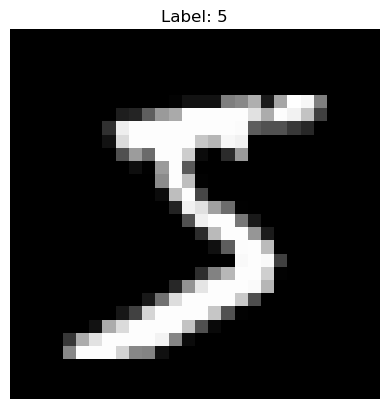

In [43]:
# View the image
plt.imshow(X_train.squeeze(), cmap="gray")
plt.title(f"Label: {y_train}")
plt.axis(False)
plt.show()

In [44]:
# Make image batch format (add extra dimension for batch size)
X_train = X_train.unsqueeze(0)
print(f"Image batch shape: {X_train.shape}")

Image batch shape: torch.Size([1, 1, 28, 28])


### Apply First Convolutional Layer

Watch how the image transforms as it passes through conv_1:
- **Input**: [1, 1, 28, 28] - 1 image, 1 channel, 28x28 pixels
- **Output**: [1, 6, 26, 26] - 1 image, 6 feature maps, 26x26 pixels
- Size reduction: 28 → 26 due to 3x3 kernel with no padding

In [45]:
# perorm convolutional layers on the image batch
x = conv_1(X_train)
print(f"After conv_1: {x.shape}")

After conv_1: torch.Size([1, 6, 26, 26])


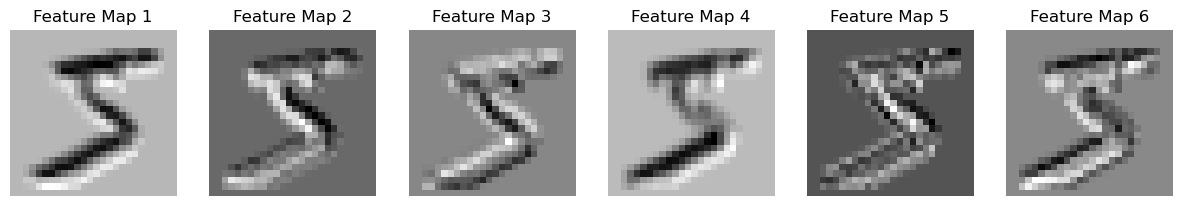

In [46]:
# View the feature maps after conv_1
fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    ax[i].imshow(x[0, i].detach(), cmap="gray")
    ax[i].set_title(f"Feature Map {i+1}")
    ax[i].axis(False)
plt.show()

### Max Pooling Operation

**Max Pooling** reduces spatial dimensions by taking the maximum value in each region:
- **Purpose**: Reduce computation, prevent overfitting, achieve translation invariance
- **Operation**: 2x2 window with stride 2 → size halves (26x26 → 13x13)

In [47]:
x = F.max_pool2d(x, kernel_size=2, stride=2)
print(f"After max pooling: {x.shape}")

After max pooling: torch.Size([1, 6, 13, 13])


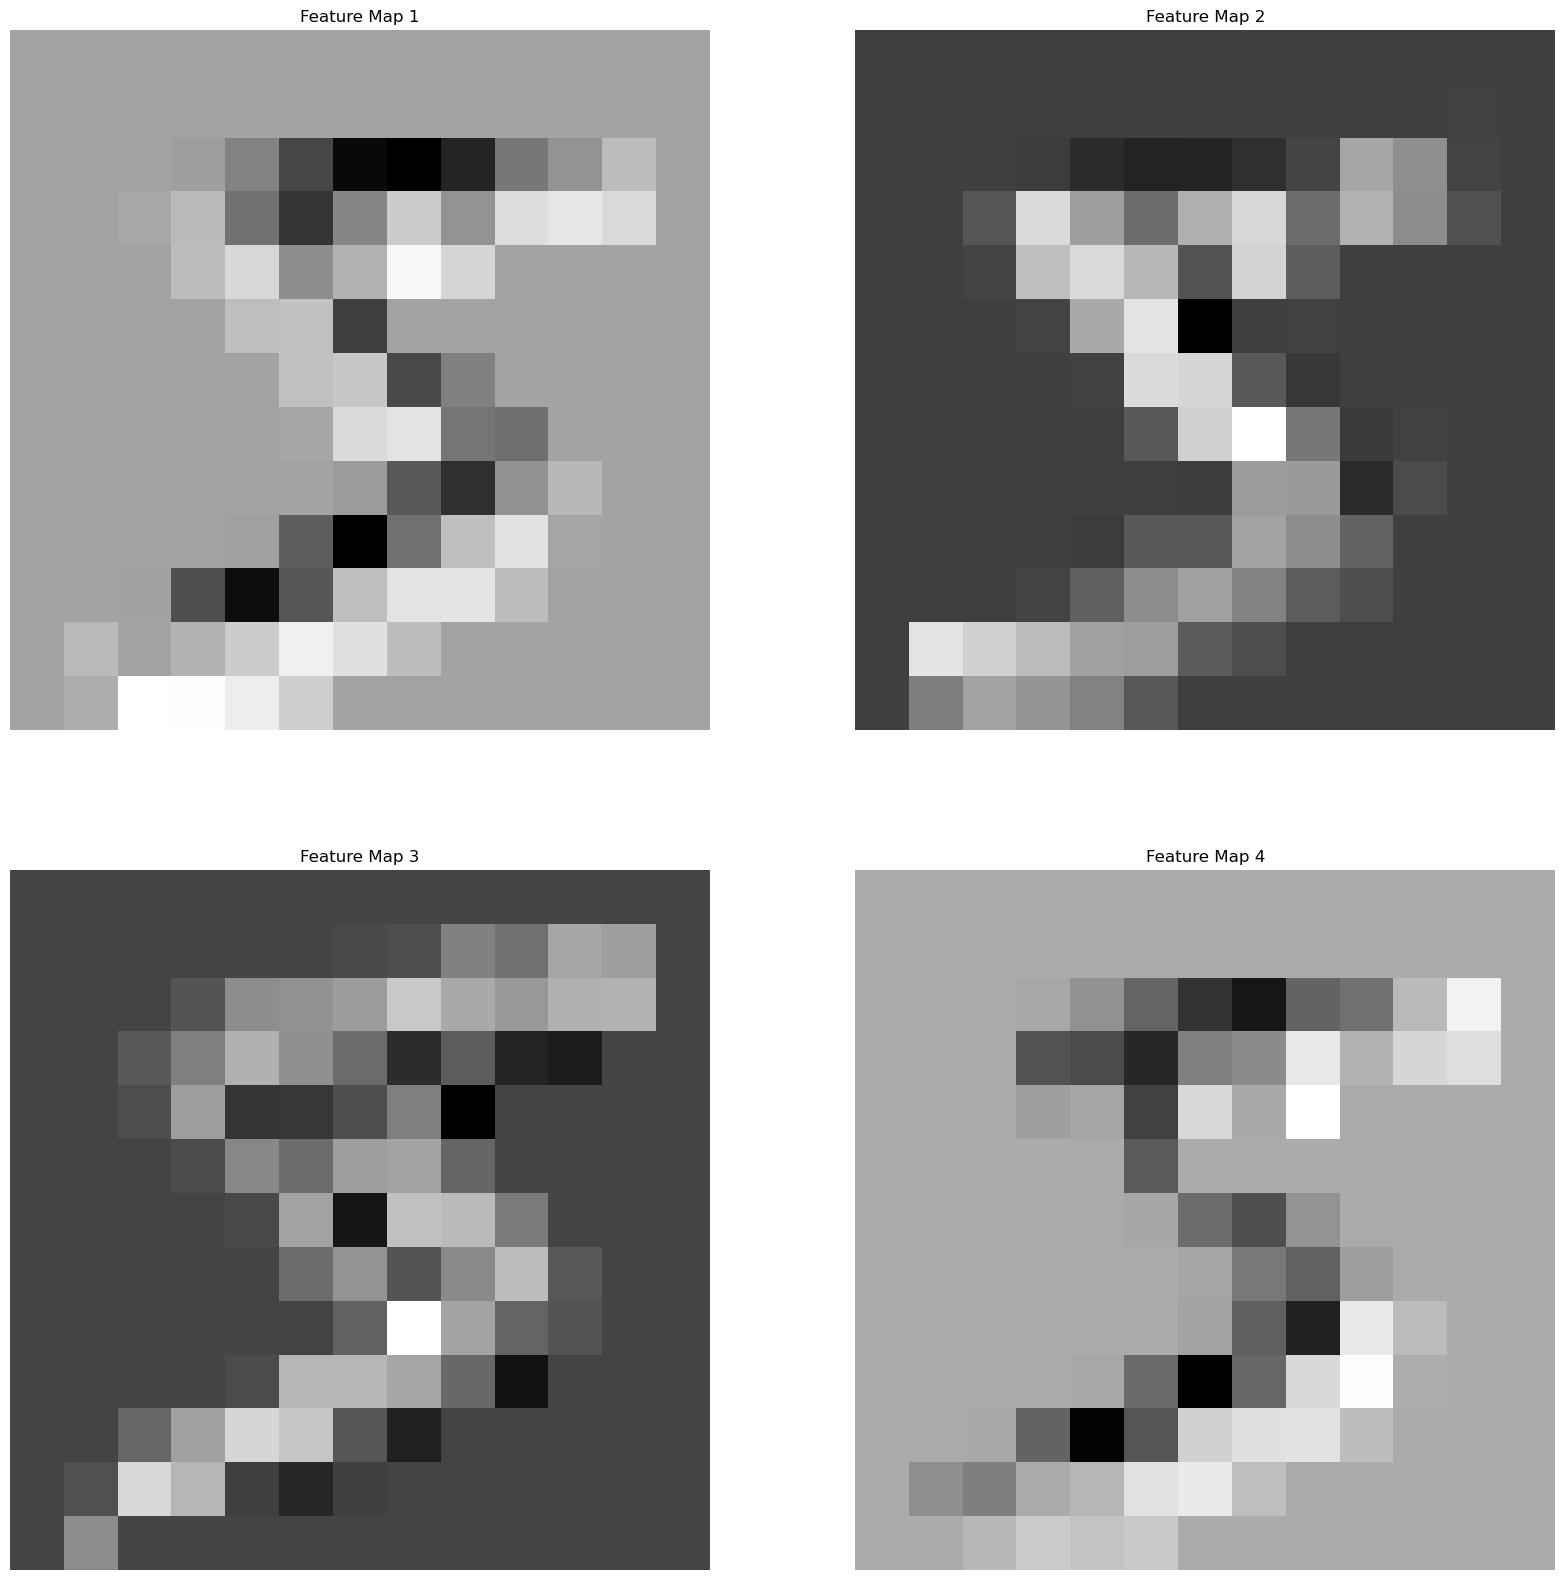

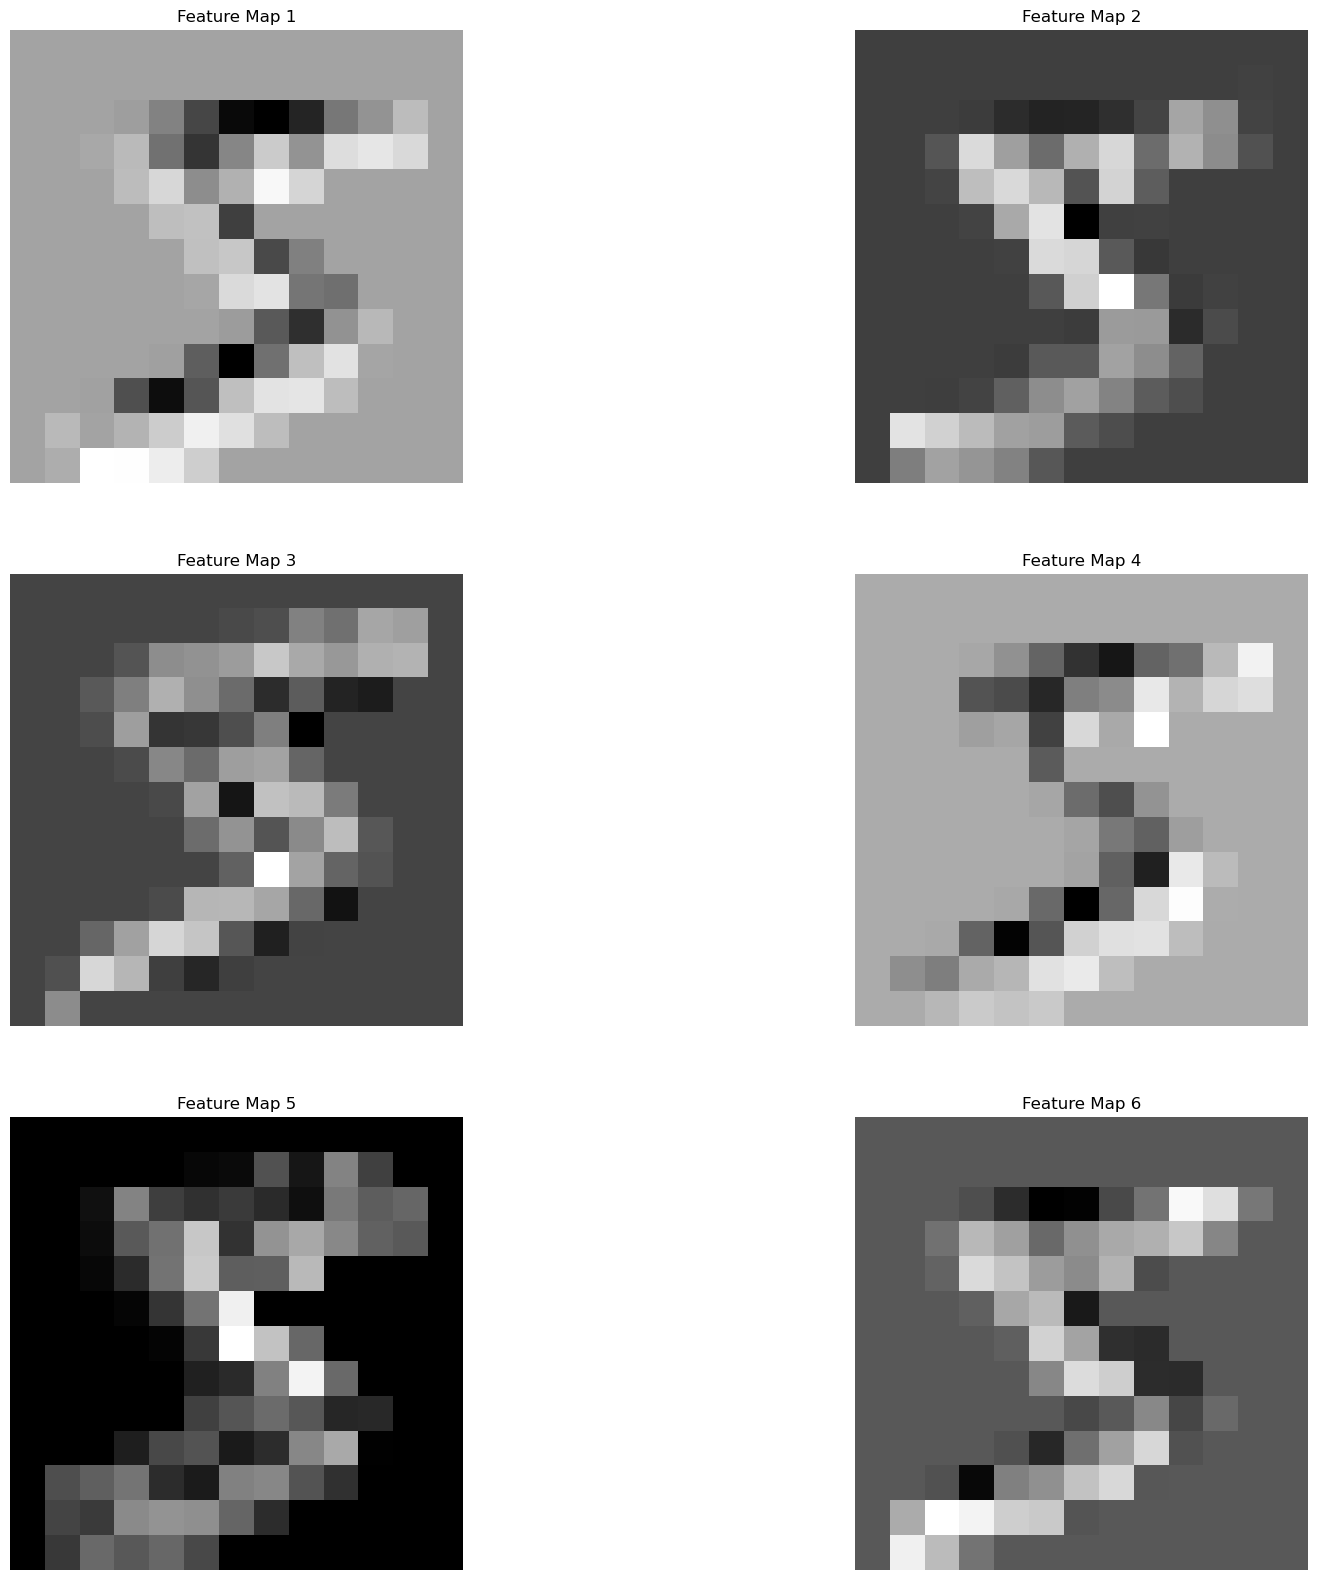

In [49]:
# View the feature maps after pooling in grid of 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
for i in range(6):
    row = i // 2
    col = i % 2
    ax[row, col].imshow(x[0, i].detach(), cmap="gray")
    ax[row, col].set_title(f"Feature Map {i+1}")
    ax[row, col].axis(False)
plt.show()

### Apply Second Convolutional Layer

The second layer learns more complex patterns from the feature maps:
- **Input**: [1, 6, 13, 13] - 6 feature maps from first layer
- **Output**: [1, 16, 11, 11] - 16 new feature maps
- Each filter looks for patterns across all 6 input channels

In [50]:
x = conv_2(x)
print(f"After conv_2: {x.shape}")

After conv_2: torch.Size([1, 16, 11, 11])


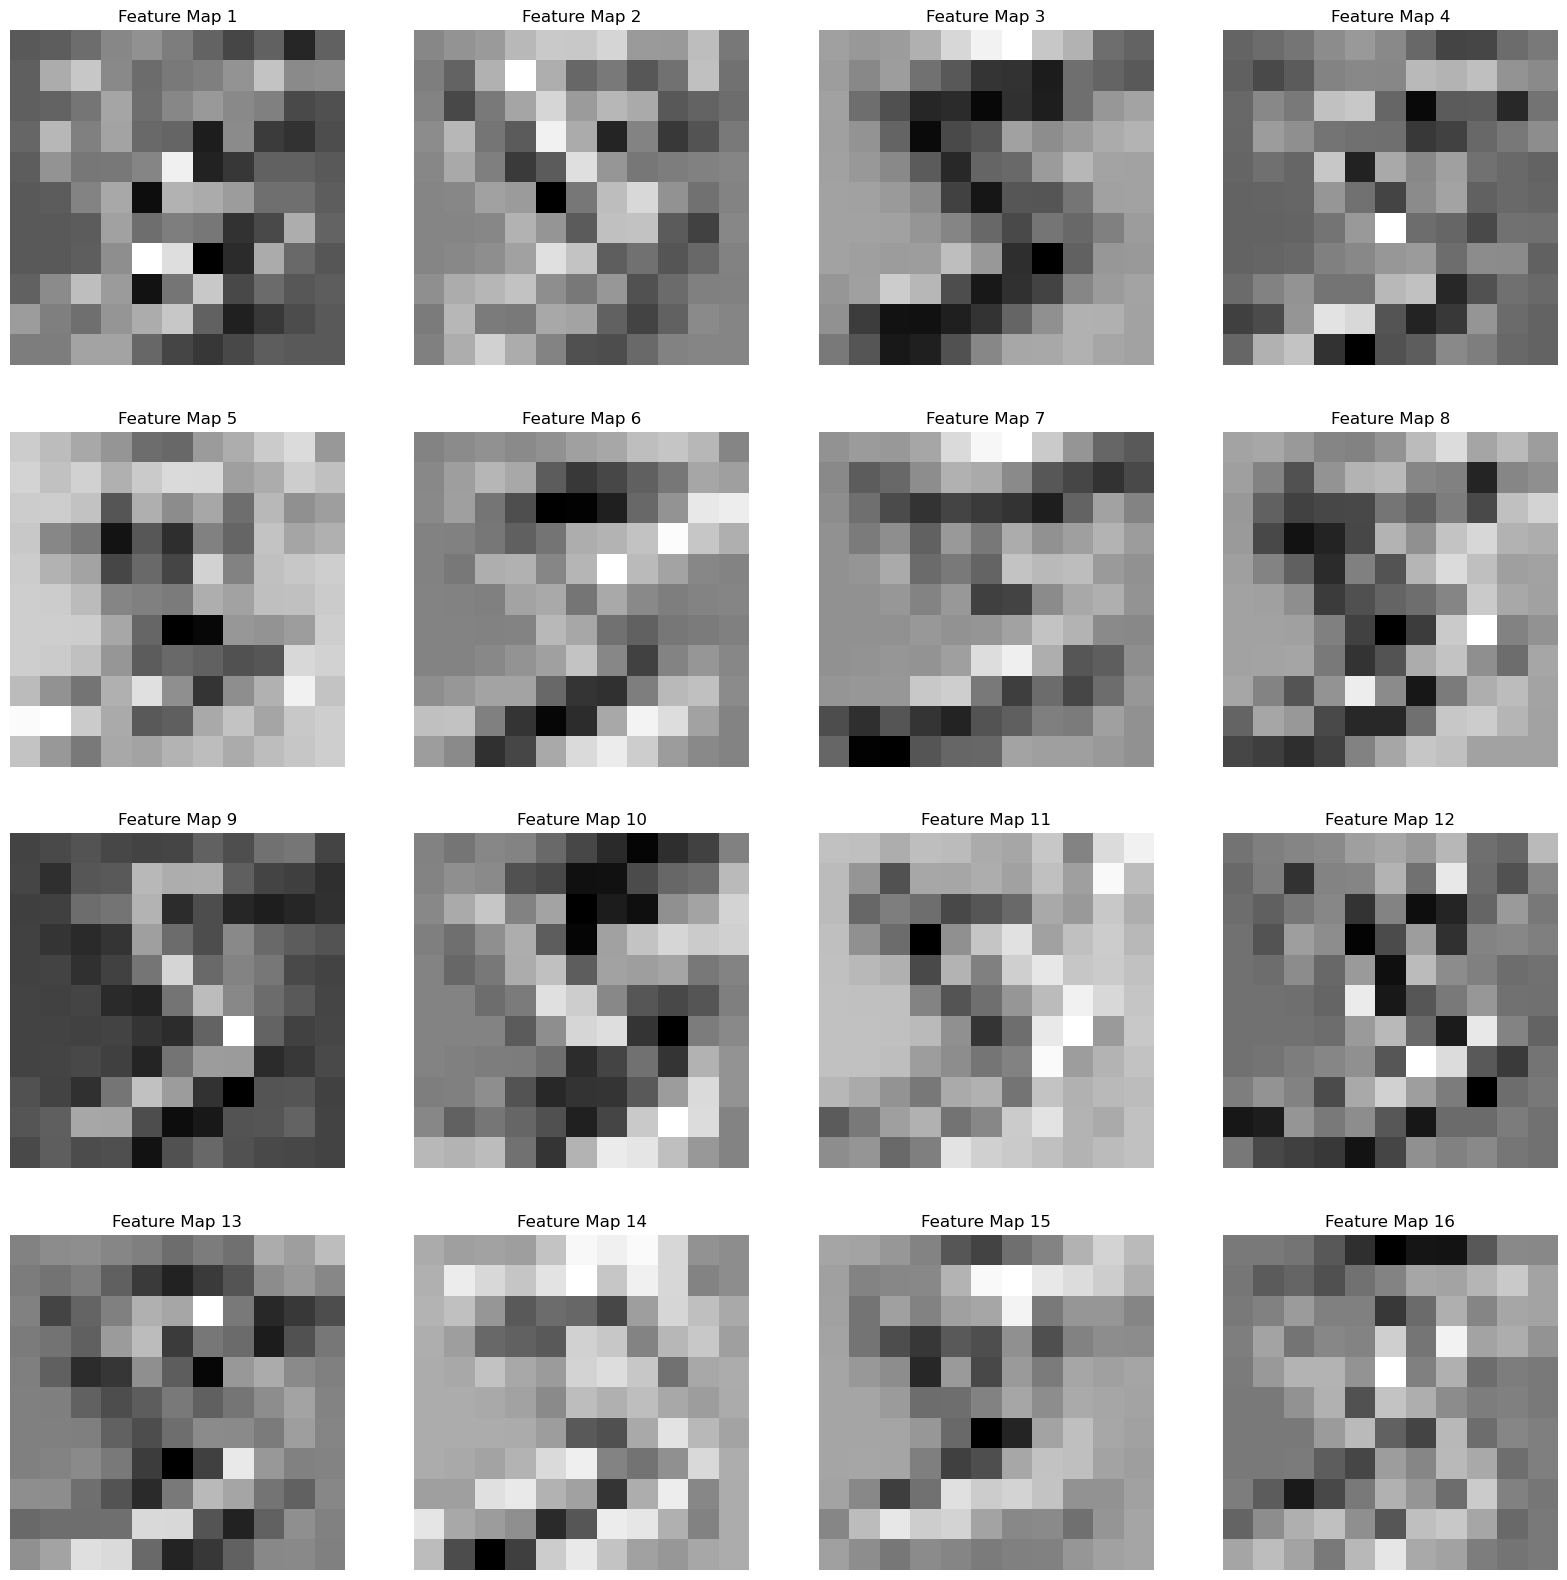

In [51]:
# View the feature maps after conv_2 in grid of 4 rows and 4 columns
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i in range(16):
    row = i // 4
    col = i % 4
    ax[row, col].imshow(x[0, i].detach(), cmap="gray")
    ax[row, col].set_title(f"Feature Map {i+1}")
    ax[row, col].axis(False)
plt.show()

### Second Max Pooling

Apply pooling again to further reduce dimensions:
- **Input**: [1, 16, 11, 11]
- **Output**: [1, 16, 5, 5]
- Final feature maps ready to feed into fully connected layers

In [52]:
x = F.max_pool2d(x, kernel_size=2, stride=2)
print(f"After max pooling: {x.shape}")

After max pooling: torch.Size([1, 16, 5, 5])


## 4. Build Complete CNN Model

Now we'll create a full CNN architecture that combines:
1. **Convolutional layers** - Extract features
2. **Pooling layers** - Reduce dimensions
3. **Fully connected layers** - Classify based on learned features

### Architecture Overview:
```
Input (28x28) 
→ Conv1 (6 filters) → ReLU → MaxPool 
→ Conv2 (16 filters) → ReLU → MaxPool 
→ Flatten 
→ FC1 (120 neurons) → ReLU 
→ FC2 (84 neurons) → ReLU 
→ FC3 (10 outputs) → LogSoftmax
```

In [53]:
# Model Class
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)

        # Fully connected layers
        self.fc_1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the feature maps into a single vector
        x = x.view(-1, 16*5*5)

        # Pass the flattened vector through the fully connected layers
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return F.log_softmax(x, dim=1)

In [55]:
# Create an instance of the model and print its architecture
torch.manual_seed(41)
model = MNISTModel()
model

MNISTModel(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

## 5. Training Setup

Configure the loss function and optimizer:
- **CrossEntropyLoss**: Measures prediction error for classification
- **Adam Optimizer**: Adaptive learning rate optimization algorithm
- **Learning rate (0.001)**: Controls how much weights change during updates

In [56]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. Train the Model

The training process uses **mini-batch gradient descent**:
- Each batch of 10 images triggers one weight update
- 60,000 training images ÷ 10 = **6,000 weight updates per epoch**
- Over 5 epochs = **30,000 total weight updates**

### Training vs Testing:
- **Training**: Model learns by updating weights via backpropagation
- **Testing**: Model evaluation only (no weight updates) to measure generalization

In [ ]:
import time
start_time = time.time()

# Training configuration
epochs = 5  # Number of complete passes through the training dataset
train_losses = []  # Store loss for each batch (6,000 per epoch)
test_losses = []   # Store loss for each test batch
train_correct = []  # Store accuracy per epoch
test_correct = []   # Store test accuracy per epoch

# Main training loop - processes all 60,000 training images multiple times
for epoch in range(epochs):
    trn_correct = 0  # Reset correct predictions counter for this epoch
    tst_correct = 0  # Reset test correct predictions counter

    # TRAINING PHASE - Model learns from training data
    model.train()  # Enable training mode (activates dropout, batch norm, etc.)
    
    # Process training data in batches of 10 images
    # With 60,000 images and batch_size=10, this loop runs 6,000 times per epoch
    # Weights are updated 6,000 times per epoch (once per batch)
    for data, target in train_loader:
        # data shape: [10, 1, 28, 28] - 10 images, 1 channel (grayscale), 28x28 pixels
        # target shape: [10] - 10 labels (one for each image in the batch)
        
        # Step 1: Clear old gradients from previous batch
        optimizer.zero_grad()
        
        # Step 2: Forward pass - get predictions for this batch of 10 images
        output = model(data)  # output shape: [10, 10] - 10 images, 10 class scores

        # Step 3: Calculate loss - how wrong are the predictions?
        loss = loss_fn(output, target)
        
        # Step 4: Backward pass - compute gradients for all weights
        loss.backward()
        
        # Step 5: Update weights using the gradients (THIS IS WHERE LEARNING HAPPENS)
        optimizer.step()

        # Track training metrics for visualization
        train_losses.append(loss.item())  # Record loss for this batch
        pred = output.argmax(dim=1, keepdim=True)  # Get predicted class (highest score)
        trn_correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions

    # TESTING PHASE - Evaluate model on unseen data (no training, just evaluation)
    model.eval()  # Disable training mode (disables dropout, etc.)
    
    # Disable gradient calculation to save memory and speed up computation
    with torch.no_grad():
        # Process test data in batches of 10 images
        for data, target in test_loader:
            # Forward pass only - NO backpropagation or weight updates
            output = model(data)
            loss = loss_fn(output, target)

            # Track testing metrics
            test_losses.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            tst_correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate accuracy for this epoch
    # Accuracy = (correct predictions) / (total samples)
    train_correct.append(trn_correct / len(train_loader.dataset))  # 60,000 training images
    test_correct.append(tst_correct / len(test_loader.dataset))    # 10,000 test images
    
    # Print progress after each epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Accuracy: {train_correct[-1]*100:.2f}%, "
          f"Test Accuracy: {test_correct[-1]*100:.2f}%")

# Display total training time
current_time = time.time()
elapsed_time = current_time - start_time
print(f"Training time: {elapsed_time/60:.2f} minutes")

Epoch 1/5, Train Accuracy: 93.77%, Test Accuracy: 97.66%
Epoch 2/5, Train Accuracy: 98.02%, Test Accuracy: 98.29%
Epoch 3/5, Train Accuracy: 98.58%, Test Accuracy: 98.07%
Epoch 4/5, Train Accuracy: 98.90%, Test Accuracy: 98.78%
Epoch 5/5, Train Accuracy: 99.16%, Test Accuracy: 98.71%
Training time: 3.53 minutes


## 7. Visualize Training Progress

Plot loss and accuracy curves to understand how the model learned:
- **Loss curves**: Should decrease over time (model getting better)
- **Accuracy curves**: Should increase over time
- **Train vs Test**: Similar curves indicate good generalization; large gap suggests overfitting

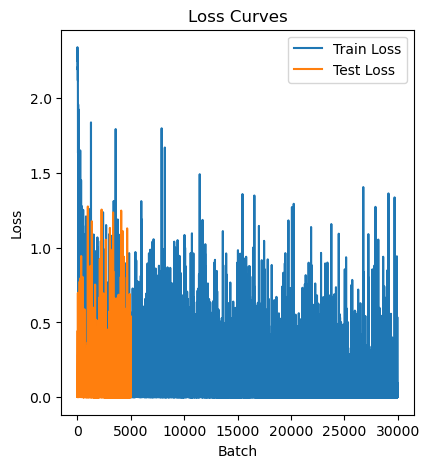

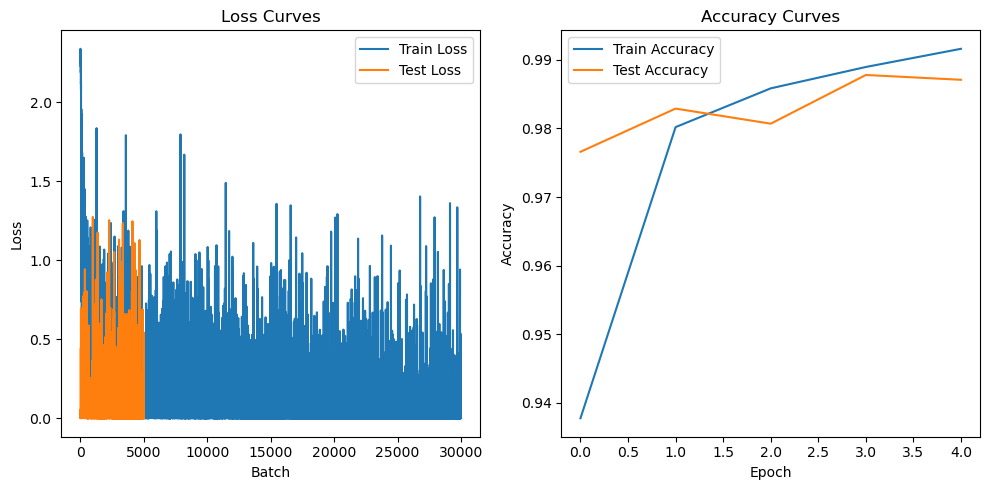

In [60]:
# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_correct, label="Train Accuracy")
plt.plot(test_correct, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Test Individual Predictions

Make predictions on individual test images to see the model in action.

In [66]:
# Grab an image from the test set and make a prediction
model.eval()
with torch.no_grad():
    test_img, test_label = test_data[2067]
    test_img_batch = test_img.unsqueeze(0)
    output = model(test_img_batch)
    pred_label = output.argmax(dim=1).item()
print(f"True Label: {test_label}, Predicted Label: {pred_label}")

True Label: 0, Predicted Label: 0


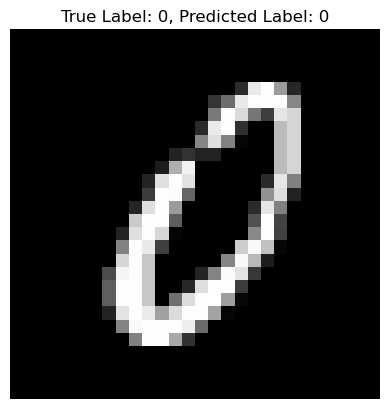

In [67]:
# View the image
plt.imshow(test_img.squeeze(), cmap="gray")
plt.title(f"True Label: {test_label}, Predicted Label: {pred_label}")
plt.axis(False)
plt.show()